# Bayesian Lasso

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### Example 1

We simulated n = 20 data set to fit models and n = 200 data set
to compare prediction errors of proposed models with eight predictors. We let
$β = (3, 1.5, 0, 0, 2, 0, 0, 0)′$ and $σ = 3$. The pairwise correlation between $x_i$ and $x_j$
was set to be $corr(i, j) = 0.5^{|i−j|}$

In [2]:
# Parameters
n_train = 20  # Number of training samples
n_test = 200  # Number of testing samples
p = 8         # Number of predictors
beta1 = np.array([3, 1.5, 0, 0, 2, 0, 0, 0])  # True regression coefficients
sigma = 3     # Standard deviation of noise
corr_decay = 0.5

# Create covariance matrix based on corr(i, j) = 0.5^|i-j|
cov_matrix = np.fromfunction(
    lambda i, j: corr_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Generate training predictors and noise
X_train = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_train)
epsilon_train = np.random.normal(loc=0, scale=1, size=n_train)

# Generate training response (y)
y_train = X_train @ beta1 + sigma * epsilon_train

# Generate testing predictors and noise
X_test = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_test)
epsilon_test = np.random.normal(loc=0, scale=1, size=n_test)

# Generate testing response (y)
y_test = X_test @ beta1 + sigma * epsilon_test

# Output data
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (20, 8) (20,)
Testing data shape: (200, 8) (200,)


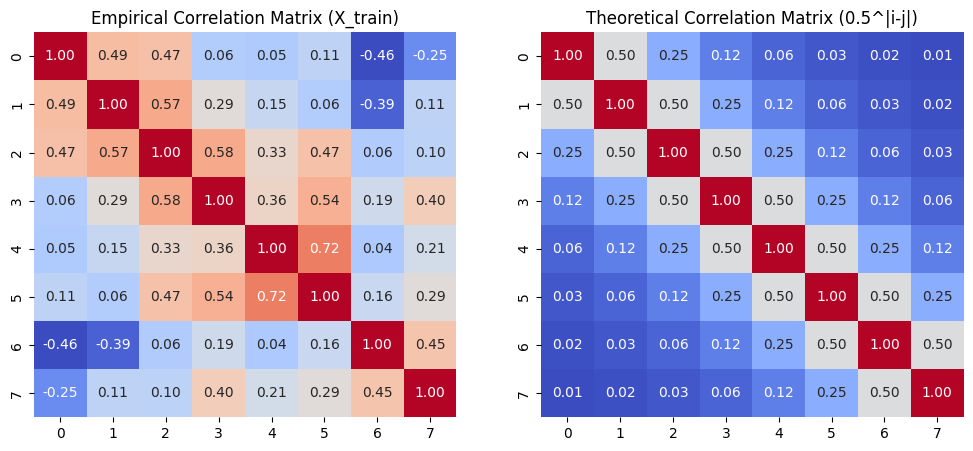

In [3]:
# Calculate empirical correlation matrix
corr_matrix = np.corrcoef(X_train, rowvar=False)

# Calculate theoretical correlation matrix
p = X_train.shape[1]
theoretical_corr_matrix = np.fromfunction(
    lambda i, j: corr_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Plot both side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[0], cbar=False)
axes[0].set_title("Empirical Correlation Matrix (X_train)")
sns.heatmap(theoretical_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[1], cbar=False)
axes[1].set_title("Theoretical Correlation Matrix (0.5^|i-j|)")

# plt.tight_layout()
plt.show()

In [4]:
# Simple linear regression model
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(lr.intercept_)
print(lr.coef_)

0.2519948545192341
[ 3.21122443  1.23706901 -0.46032303 -0.83066328  3.31951518 -0.65070102
  0.94590731  2.04124441]


##### Frequentist Lasso

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Define parameter grid for alpha (regularization parameter)
param_grid = {'alpha': [0.01, 0.1, 0.5, 0.8, 0.9, 1, 1.1, 2, 5, 10]}

# Perform Grid Search with Cross-Validation
grid = GridSearchCV(Lasso(fit_intercept=True), param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Retrieve the best alpha and corresponding model
best_alpha = grid.best_params_['alpha']
best_model = grid.best_estimator_

# Predictions using the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Evaluation
mse_train_freq = mean_squared_error(y_train, y_pred_train)
mse_test_freq = mean_squared_error(y_test, y_pred_test)

# Print the results
print("Frequentist Lasso Results with Hyperparameter Tuning:")
print(f"Best alpha: {best_alpha}")
print(f"Train MSE: {mse_train_freq:.3f}")
print(f"Test MSE: {mse_test_freq:.3f}")
print("Best Coefficients:", best_model.coef_)

Frequentist Lasso Results with Hyperparameter Tuning:
Best alpha: 0.5
Train MSE: 7.746
Test MSE: 15.816
Best Coefficients: [ 2.19161164  0.79599005  0.         -0.          2.07806703  0.
  0.          1.37468068]


In [6]:
for i, column in enumerate(range(X_train.shape[1])):
    print(f"Predictor {i+1} correlation with y_train: {np.corrcoef(X_train[:, column], y_train)[0, 1]:.2f}")

Predictor 1 correlation with y_train: 0.57
Predictor 2 correlation with y_train: 0.55
Predictor 3 correlation with y_train: 0.48
Predictor 4 correlation with y_train: 0.26
Predictor 5 correlation with y_train: 0.54
Predictor 6 correlation with y_train: 0.40
Predictor 7 correlation with y_train: -0.09
Predictor 8 correlation with y_train: 0.32


In [7]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=1, l1_ratio=0.7)
elastic_net.fit(X_train, y_train)
print("Elastic Net Coefficients:", elastic_net.coef_)

Elastic Net Coefficients: [1.41960088 0.89593282 0.03231782 0.         1.35116327 0.
 0.         0.73516633]


##### Bayesian Lasso

(Using NUTS and not Gibbs sampling)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda, tau, beta, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2009 seconds.
There were 262 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],2.516,0.875,0.530,3.990,0.028,0.020,1040.0,1075.0,1.01
beta[1],0.772,0.690,-0.296,2.204,0.023,0.016,953.0,1435.0,1.01
beta[2],0.019,0.626,-1.473,1.280,0.021,0.015,996.0,1008.0,1.00
beta[3],-0.226,0.662,-1.695,1.052,0.018,0.014,1514.0,1542.0,1.00
beta[4],2.327,1.026,0.061,4.142,0.032,0.023,1018.0,1065.0,1.00
beta[5],-0.011,0.787,-1.716,1.684,0.022,0.016,1331.0,1495.0,1.00
beta[6],0.271,0.610,-0.870,1.676,0.017,0.013,1431.0,1323.0,1.00
beta[7],1.516,0.894,-0.142,3.063,0.026,0.018,1205.0,1887.0,1.00
intercept,1.146,0.889,-0.626,2.795,0.028,0.020,1012.0,1265.0,1.00


Bayesian Lasso Results:
Posterior Means for Coefficients: <xarray.DataArray 'beta' (beta_dim_0: 8)> Size: 64B
array([ 2.51591623,  0.77209106,  0.0192286 , -0.22598574,  2.32704545,
       -0.01074431,  0.27060412,  1.51551926])
Coordinates:
  * beta_dim_0  (beta_dim_0) int32 32B 0 1 2 3 4 5 6 7
Posterior Mean for Intercept: <xarray.DataArray 'intercept' ()> Size: 8B
array(1.14628444)


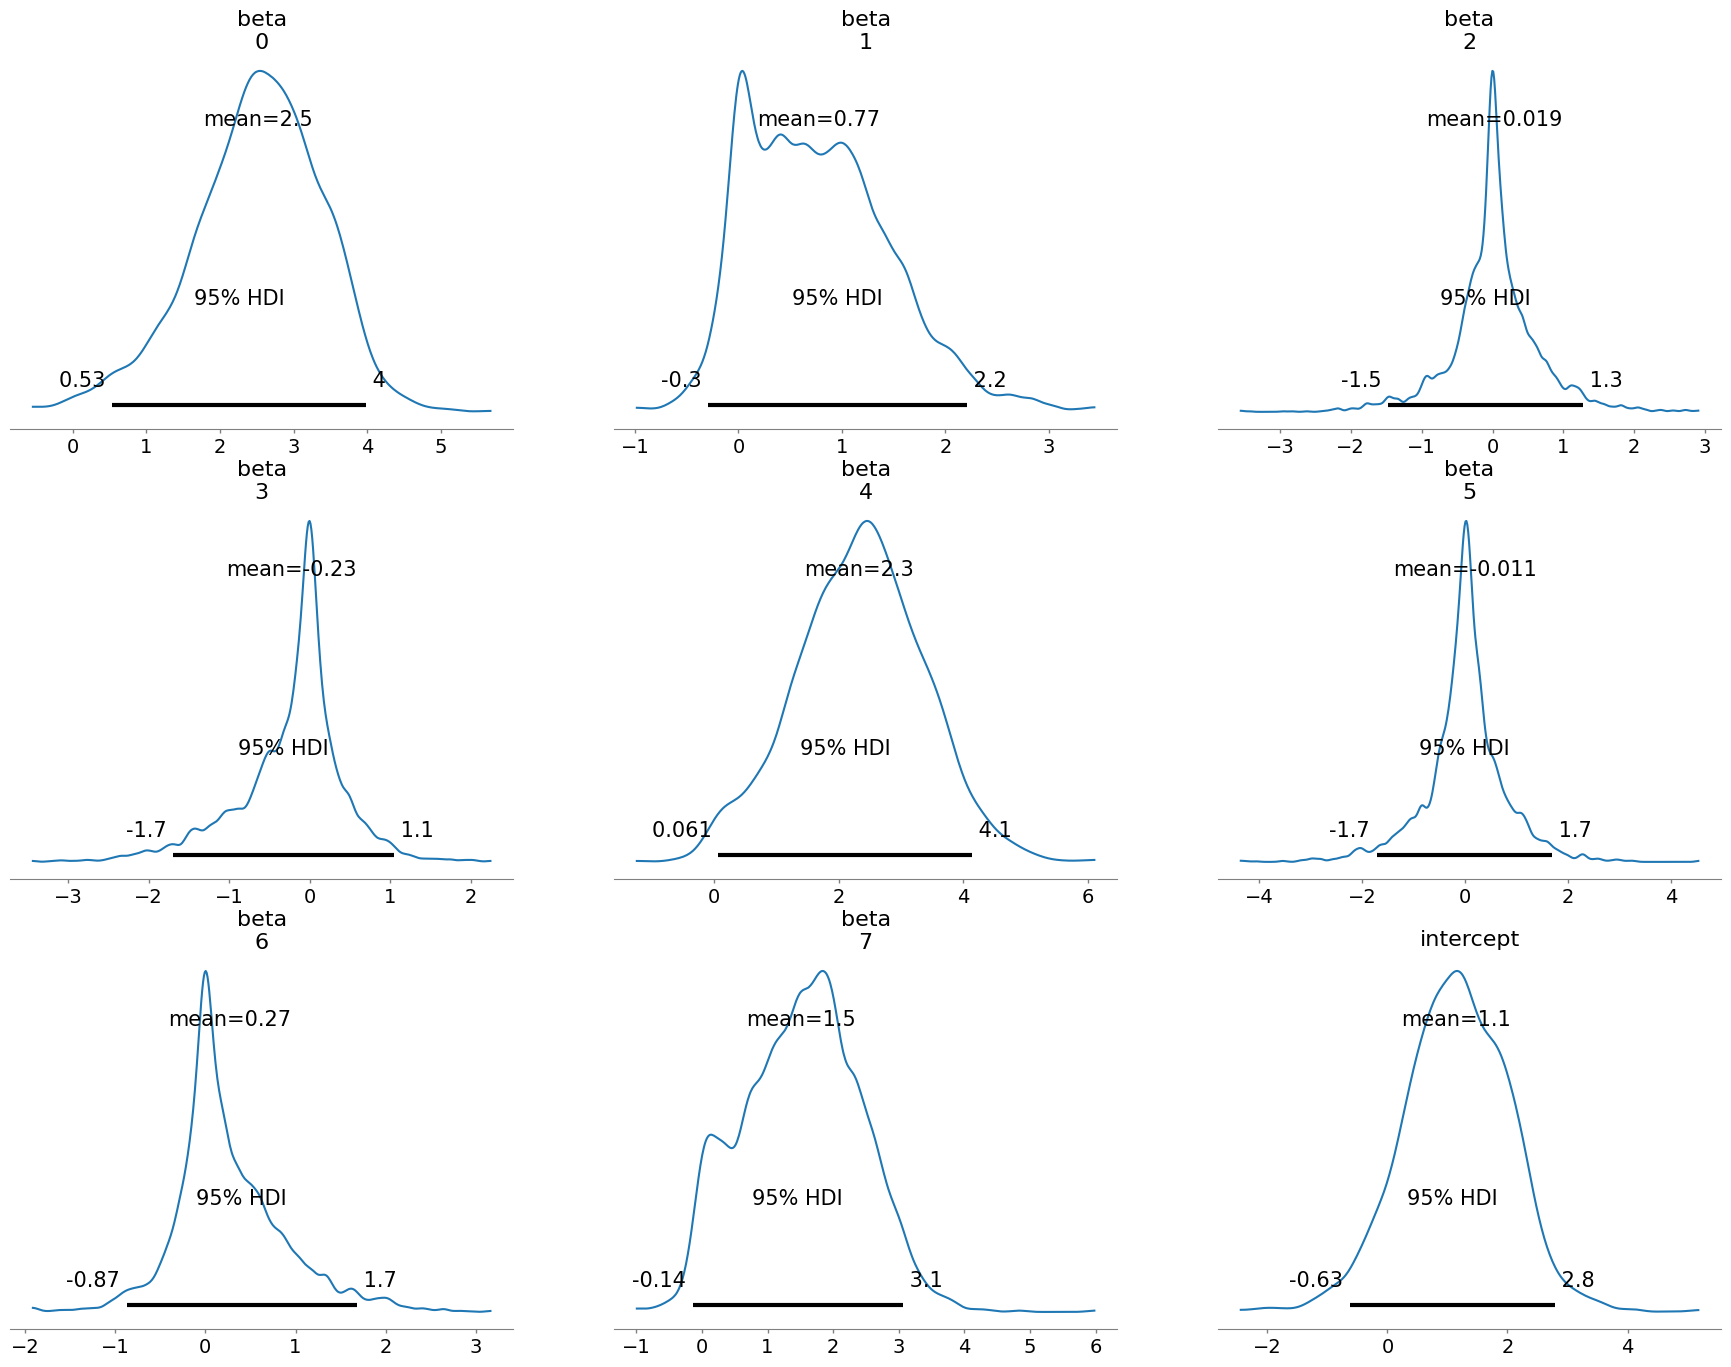

In [8]:
a = 1  # Shape parameter for Gamma prior
b = 0.1  # Scale parameter for Gamma prior

with pm.Model() as bayesian_lasso:
    # Prior for regularization parameter lambda
    lambda_param = pm.Gamma("lambda", alpha=a, beta=b)
    
    # Priors for the regression coefficients
    tau = pm.Exponential("tau", lambda_param, shape=X_train.shape[1])
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=X_train.shape[1])
    
    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Likelihood (data model)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = intercept + pm.math.dot(X_train, beta)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train)

    # Inference
    trace = pm.sample(1000, tune=1000, target_accept=0.9,  return_inferencedata=True, progressbar=True)

# Posterior summaries
pm.plot_posterior(trace, var_names=["beta", "intercept"], hdi_prob=0.95)

summary = az.summary(trace, var_names=["beta", "intercept"], hdi_prob=0.95)
display(summary)

# Retrieve the posterior means for the coefficients
beta_post_mean = trace.posterior["beta"].mean(axis=(0,1))
intercept_post_mean = trace.posterior["intercept"].mean()
print("Bayesian Lasso Results:")
print("Posterior Means for Coefficients:", beta_post_mean)
print("Posterior Mean for Intercept:", intercept_post_mean)

In [ ]:
# Posterior Predictions
with bayesian_lasso:
    posterior_predictive = pm.sample_posterior_predictive(trace)

posterior_predictive_data = posterior_predictive['posterior_predictive']
# print("Available keys inside posterior_predictive:", list(posterior_predictive_data.keys()))

# Extract the predictions
y_pred_samples = posterior_predictive_data['y'].values
# Compute posterior mean of y for each observation (across all chains and draws)
y_pred_mean = y_pred_samples.mean(axis=(0, 1))  # Averaging over chains (axis=0) and draws (axis=1)
# Extract observed y values
y_obs = posterior_predictive['observed_data']['y'].values

# Compute the Mean Squared Error (MSE)
mse = mean_squared_error(y_obs, y_pred_mean)
print(f"MSE: {mse:.3f}")

Sampling: [y]


Output()

Mean Squared Error (MSE): 7.001


In [ ]:
# Generate predictions for the test dataset
with bayesian_lasso:
    # Extract posterior samples of beta and intercept
    beta_samples = trace.posterior["beta"].stack(samples=("chain", "draw")).values
    intercept_samples = trace.posterior["intercept"].stack(samples=("chain", "draw")).values

# Compute predicted means for X_test
y_pred_test_samples = np.dot(X_test, beta_samples) + intercept_samples
# Compute posterior predictive mean (average over all samples)
y_pred_test_mean = y_pred_test_samples.mean(axis=1)  # Averaging over all posterior samples

# Compute the Mean Squared Error (MSE) for the test set
mse_test = mean_squared_error(y_test, y_pred_test_mean)
print(f"MSE on Test Set: {mse_test:.3f}")

Comparisons

In [10]:
# True coefficients
print("True beta: ", beta1)
# np.array([3, 1.5, 0, 0, 2, 0, 0, 0])

# Frequentist Lasso Coefficients
print('----- FREQUENTIST LASSO -----')
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=5).fit(X_train, y_train)
print("\nFrequentist Lasso Coefficients:", lasso.coef_)
print(f"\nMSE on Train Set: {mse_train_freq:.3f}")
print(f"\nMSE on Test Set: {mse_test_freq:.3f}")

# Bayesian Lasso Posterior Means
print('\n----- BAYESIAN LASSO -----')
beta_post_mean = trace.posterior["beta"].mean(axis=(0, 1))
print("\nBayesian Lasso Posterior Means:", beta_post_mean)
print(f"\nMSE on Train Set: {mse:.3f}")
print(f"\nMSE on Test Set: {mse_test:.3f}")

True beta:  beta

Frequentist Lasso Coefficients: [ 2.3111076   0.79462455  0.         -0.          2.18244108  0.
  0.          1.51480814]

Bayesian Lasso Posterior Means: <xarray.DataArray 'beta' (beta_dim_0: 8)> Size: 64B
array([ 2.51591623,  0.77209106,  0.0192286 , -0.22598574,  2.32704545,
       -0.01074431,  0.27060412,  1.51551926])
Coordinates:
  * beta_dim_0  (beta_dim_0) int32 32B 0 1 2 3 4 5 6 7


In [ ]:
# # Generate synthetic data
# np.random.seed(42)
# n, p = 100, 10  # Number of observations and predictors
# X = np.random.normal(size=(n, p))
# true_beta = np.array([3, 1.5, 0, 0, 2, 0, 0, 0, 0])
# y = X @ true_beta + np.random.normal(0, 1, size=n)

# # Bayesian Hierarchical Elastic Net Model
# with pm.Model() as hierarchical_elastic_net:
#     # Hyperpriors for lambda_1 and lambda_2
#     lambda_1 = pm.HalfCauchy("lambda_1", beta=2.5)
#     lambda_2 = pm.HalfCauchy("lambda_2", beta=2.5)
    
#     # Residual variance
#     sigma = pm.HalfNormal("sigma", sigma=1)
    
#     # Priors for beta
#     beta = pm.Normal("beta", mu=0, sigma=lambda_2 / sigma, shape=p)
    
#     # Observed likelihood
#     y_obs = pm.Normal("y_obs", mu=pm.math.dot(X, beta), sigma=sigma, observed=y)
    
#     # Sampling
#     trace = pm.sample(1000, tune=1000, return_inferencedata=True, progressbar=True)
    
# # Posterior summaries
# pm.summary(trace, hdi_prob=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_1, lambda_2, sigma, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 453 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],2.887,0.115,2.666,3.107,0.001,0.001,6222.0,3079.0,1.0
beta[1],1.433,0.104,1.216,1.625,0.001,0.001,5579.0,3489.0,1.0
beta[2],-0.027,0.100,-0.218,0.162,0.001,0.002,7077.0,3039.0,1.0
beta[3],0.041,0.105,-0.168,0.237,0.001,0.001,5868.0,3654.0,1.0
beta[4],1.867,0.101,1.670,2.067,0.001,0.001,7037.0,3148.0,1.0
beta[5],0.061,0.103,-0.143,0.259,0.001,0.001,5583.0,3170.0,1.0
beta[6],-0.205,0.108,-0.411,0.014,0.001,0.001,6546.0,3103.0,1.0
beta[7],0.007,0.113,-0.220,0.224,0.001,0.002,7166.0,2323.0,1.0
beta[8],0.048,0.113,-0.174,0.273,0.001,0.002,6445.0,3514.0,1.0
beta[9],-0.061,0.101,-0.247,0.145,0.001,0.001,5734.0,3322.0,1.0


#### Example 2 

Example 2 is the same as Example 1, except that $β_j = 0.85$ for all $j$.

In [35]:
# Parameters
n_train = 20  # Number of training samples
n_test = 200  # Number of testing samples
p = 8         # Number of predictors
beta2 = np.array([0.85]*8)  # True regression coefficients
sigma = 3     # Standard deviation of noise
corr_decay = 0.5

# Create covariance matrix based on corr(i, j) = 0.5^|i-j|
cov_matrix = np.fromfunction(
    lambda i, j: corr_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Generate training predictors and noise
X_train = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_train)
epsilon_train = np.random.normal(loc=0, scale=1, size=n_train)

# Generate training response (y)
y_train = X_train @ beta2 + sigma * epsilon_train

# Generate testing predictors and noise
X_test = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_test)
epsilon_test = np.random.normal(loc=0, scale=1, size=n_test)

# Generate testing response (y)
y_test = X_test @ beta2 + sigma * epsilon_test

# Output data
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (20, 8) (20,)
Testing data shape: (200, 8) (200,)


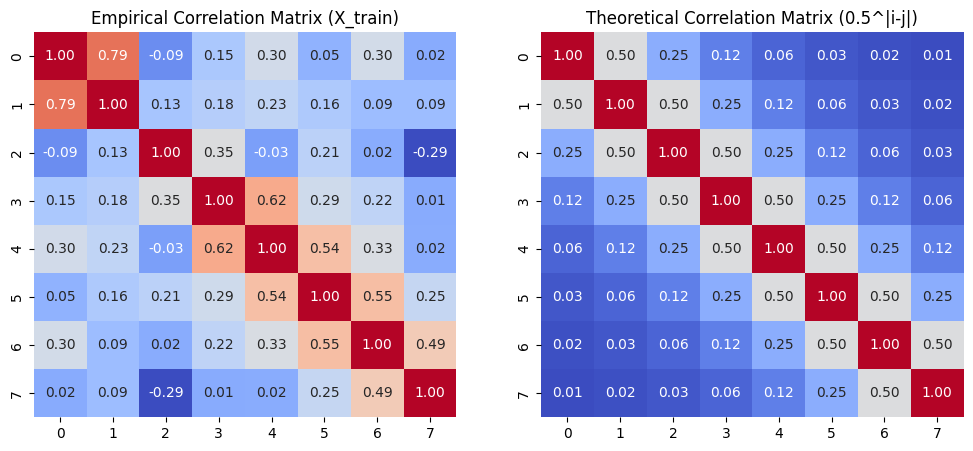

In [36]:
# Calculate empirical correlation matrix
corr_matrix = np.corrcoef(X_train, rowvar=False)

# Calculate theoretical correlation matrix
p = X_train.shape[1]
theoretical_corr_matrix = np.fromfunction(
    lambda i, j: corr_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Plot both side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[0], cbar=False)
axes[0].set_title("Empirical Correlation Matrix (X_train)")
sns.heatmap(theoretical_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[1], cbar=False)
axes[1].set_title("Theoretical Correlation Matrix (0.5^|i-j|)")

plt.show()

In [37]:
# Simple linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(lr.intercept_)
print(lr.coef_)

-0.4154783076608822
[ 0.48926847  1.13176588  1.30364829  0.14463081  0.99707906  0.86232325
  1.42966025 -0.37121893]


##### Frequentist Lasso

In [38]:
# Define parameter grid for alpha (regularization parameter)
param_grid = {'alpha': [0.01, 0.1, 0.5, 0.9, 1, 2, 3, 5, 10]}

# Perform Grid Search with Cross-Validation
grid = GridSearchCV(Lasso(fit_intercept=True), param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Retrieve the best alpha and corresponding model
best_alpha = grid.best_params_['alpha']
best_model = grid.best_estimator_

# Predictions using the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Evaluation
mse_train_freq = mean_squared_error(y_train, y_pred_train)
mse_test_freq = mean_squared_error(y_test, y_pred_test)

# Print the results
print("Frequentist Lasso Results with Hyperparameter Tuning:")
print(f"Best alpha: {best_alpha}")
print(f"Train MSE: {mse_train_freq:.3f}")
print(f"Test MSE: {mse_test_freq:.3f}")
print("Best Coefficients:", best_model.coef_)

Frequentist Lasso Results with Hyperparameter Tuning:
Best alpha: 0.1
Train MSE: 4.555
Test MSE: 11.320
Best Coefficients: [ 0.67343533  0.84027574  1.36975036  0.08119446  1.05698148  0.8426467
  1.08860929 -0.        ]


Very poor results, all coeffs to zero

In [39]:
#test of an ElasticNet : also bad
elastic_net = ElasticNet(alpha=1, l1_ratio=0.7)
elastic_net.fit(X_train, y_train)
print("Elastic Net Coefficients:", elastic_net.coef_)

Elastic Net Coefficients: [0.34188166 0.41807015 0.55604468 0.23249932 0.80465527 0.69145978
 0.40988366 0.        ]


##### Bayesian Lasso

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda, tau, beta, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1741 seconds.
There were 305 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.543,0.710,-0.511,2.156,0.022,0.016,1073.0,1642.0,1.00
beta[1],0.667,0.713,-0.466,2.175,0.023,0.016,1004.0,2095.0,1.01
beta[2],0.376,0.504,-0.411,1.473,0.018,0.014,869.0,505.0,1.00
beta[3],0.692,0.607,-0.299,1.893,0.017,0.012,1272.0,2027.0,1.00
beta[4],0.421,0.788,-0.875,2.228,0.027,0.019,954.0,1104.0,1.01
beta[5],1.691,0.709,0.224,3.048,0.023,0.016,992.0,1376.0,1.00
beta[6],-0.123,0.511,-1.351,0.839,0.017,0.012,944.0,1278.0,1.01
beta[7],0.748,0.706,-0.308,2.279,0.025,0.018,807.0,1083.0,1.00
intercept,0.013,0.677,-1.304,1.307,0.017,0.012,1528.0,2322.0,1.00


Bayesian Lasso Results:
Posterior Means for Coefficients: <xarray.DataArray 'beta' (beta_dim_0: 8)> Size: 64B
array([ 0.54295008,  0.66671164,  0.37633877,  0.69235068,  0.42056249,
        1.69080189, -0.12300075,  0.74845233])
Coordinates:
  * beta_dim_0  (beta_dim_0) int32 32B 0 1 2 3 4 5 6 7
Posterior Mean for Intercept: <xarray.DataArray 'intercept' ()> Size: 8B
array(0.01328204)


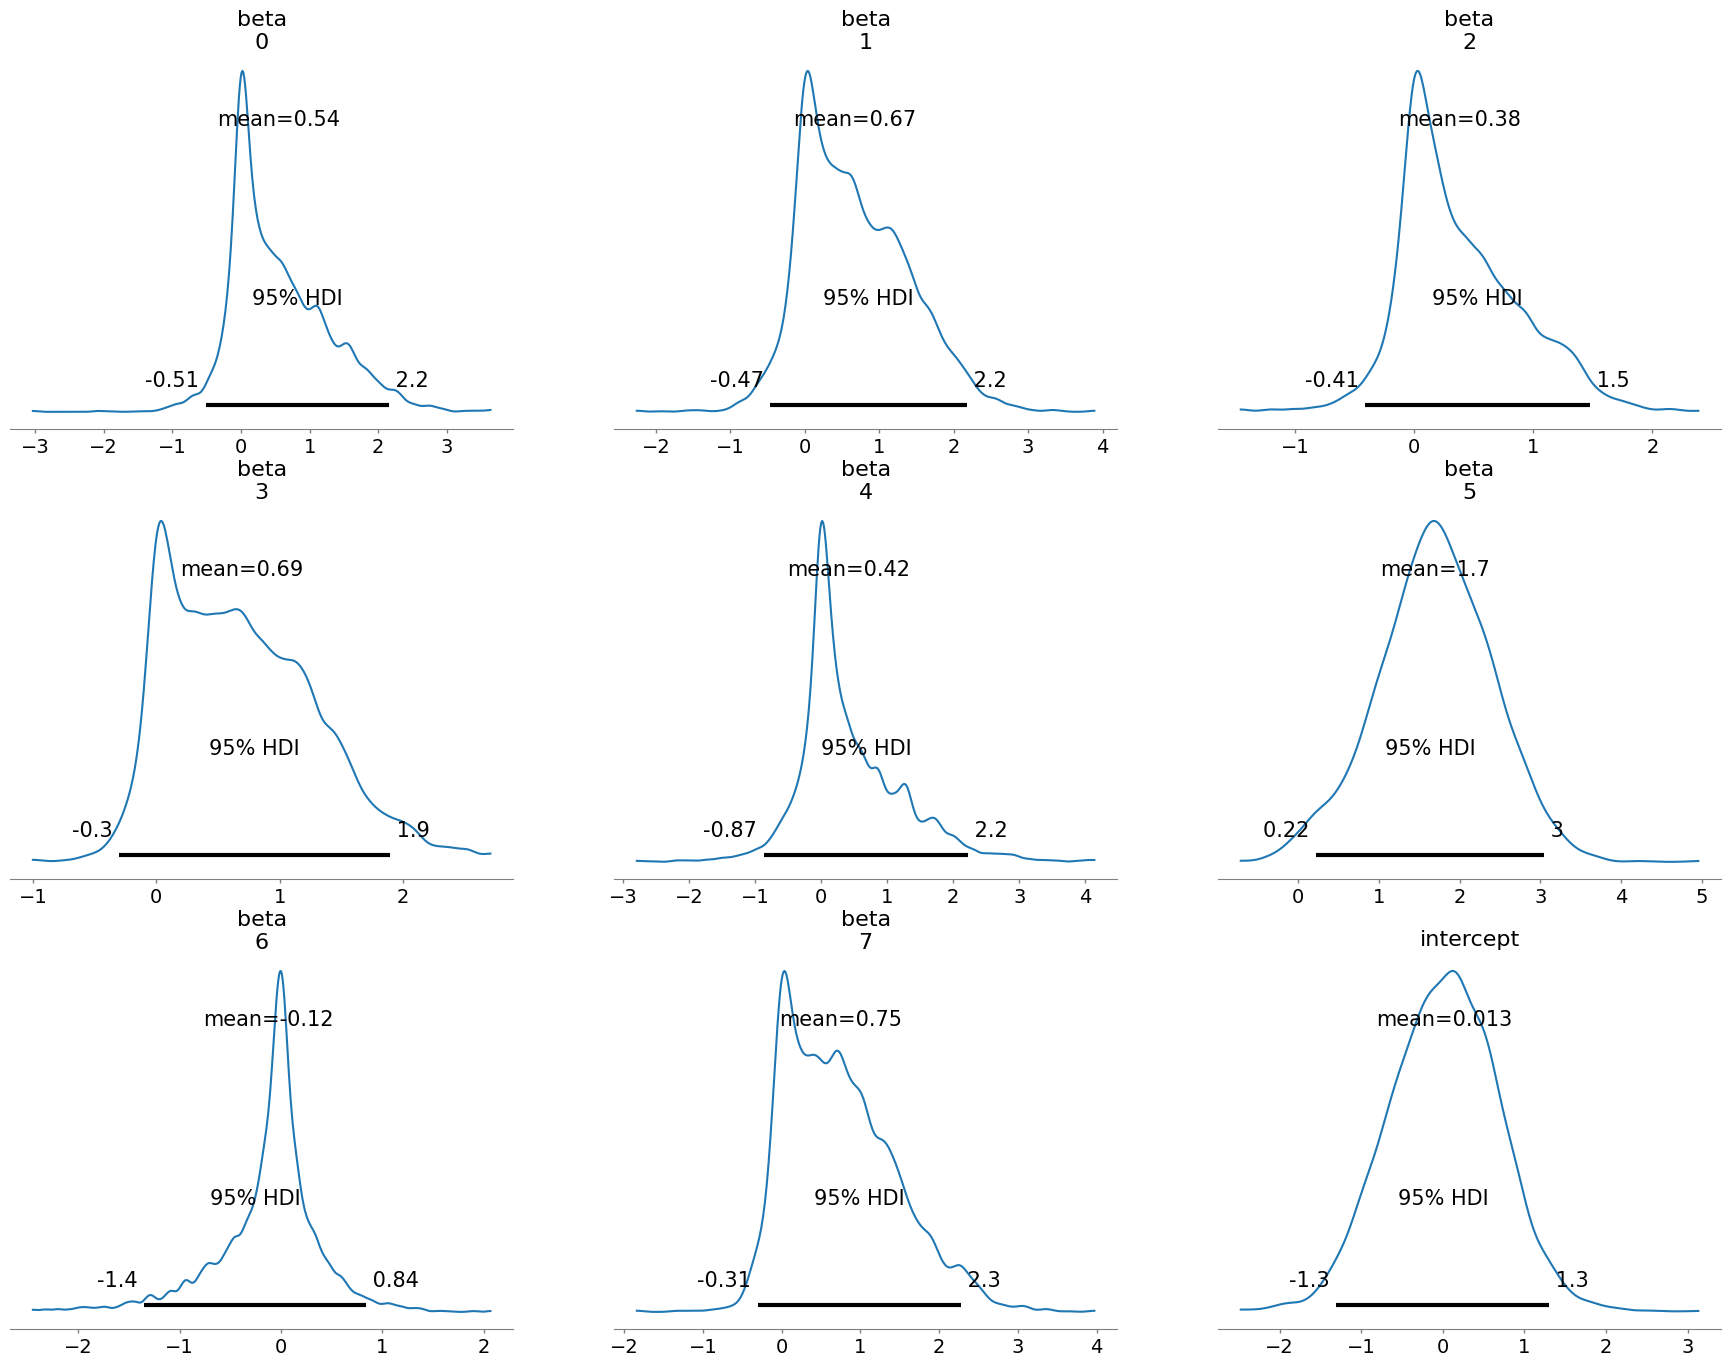

In [17]:
a = 1  # Shape parameter for Gamma prior
b = 0.1  # Scale parameter for Gamma prior

with pm.Model() as bayesian_lasso:
    # Prior for regularization parameter lambda
    lambda_param = pm.Gamma("lambda", alpha=a, beta=b)
    
    # Priors for the regression coefficients
    tau = pm.Exponential("tau", lambda_param, shape=X_train.shape[1])
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=X_train.shape[1])
    
    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Likelihood (data model)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = intercept + pm.math.dot(X_train, beta)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train)

    # Inference
    trace = pm.sample(1000, tune=1000, target_accept=0.9,  return_inferencedata=True, progressbar=True)

# Posterior summaries
pm.plot_posterior(trace, var_names=["beta", "intercept"], hdi_prob=0.95)

summary = az.summary(trace, var_names=["beta", "intercept"], hdi_prob=0.95)
display(summary)

# Retrieve the posterior means for the coefficients
beta_post_mean = trace.posterior["beta"].mean(axis=(0,1))
intercept_post_mean = trace.posterior["intercept"].mean()
print("Bayesian Lasso Results:")
print("Posterior Means for Coefficients:", beta_post_mean)
print("Posterior Mean for Intercept:", intercept_post_mean)

In [18]:
# Posterior Predictions
with bayesian_lasso:
    posterior_predictive = pm.sample_posterior_predictive(trace)

posterior_predictive_data = posterior_predictive['posterior_predictive']
# print("Available keys inside posterior_predictive:", list(posterior_predictive_data.keys()))

# Extract the predictions
y_pred_samples = posterior_predictive_data['y'].values
# Compute posterior mean of y for each observation (across all chains and draws)
y_pred_mean = y_pred_samples.mean(axis=(0, 1))  # Averaging over chains (axis=0) and draws (axis=1)
# Extract observed y values
y_obs = posterior_predictive['observed_data']['y'].values

# Compute the Mean Squared Error (MSE)
mse = mean_squared_error(y_obs, y_pred_mean)
print(f"MSE: {mse:.3f}")

Sampling: [y]


Output()

Mean Squared Error (MSE): 5.775


In [21]:
# Generate predictions for the test dataset
with bayesian_lasso:
    # Extract posterior samples of beta and intercept
    beta_samples = trace.posterior["beta"].stack(samples=("chain", "draw")).values
    intercept_samples = trace.posterior["intercept"].stack(samples=("chain", "draw")).values

# Compute predicted means for X_test
y_pred_test_samples = np.dot(X_test, beta_samples) + intercept_samples
# Compute posterior predictive mean (average over all samples)
y_pred_test_mean = y_pred_test_samples.mean(axis=1)  # Averaging over all posterior samples

# Compute the Mean Squared Error (MSE) for the test set
mse_test = mean_squared_error(y_test, y_pred_test_mean)
print(f"MSE on Test Set: {mse_test:.3f}")


Mean Squared Error (MSE) on Test Set: 12.238


Comparisons

In [ ]:
# True coefficients
print("True beta: ", beta2)

# Frequentist Lasso Coefficients
print('----- FREQUENTIST LASSO -----')
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=5).fit(X_train, y_train)
print("\nFrequentist Lasso Coefficients:", lasso.coef_)
print(f"MSE on Train Set: {mse_train_freq:.3f}")
print(f"MSE on Test Set: {mse_test_freq:.3f}")

# Bayesian Lasso Posterior Means
print('\n----- BAYESIAN LASSO -----')
beta_post_mean = trace.posterior["beta"].mean(axis=(0, 1))
print("\nBayesian Lasso Posterior Means:", beta_post_mean)
print(f"MSE on Train Set: {mse:.3f}")
print(f"MSE on Test Set: {mse_test:.3f}")

----- FREQUENTIST LASSO -----

Frequentist Lasso Coefficients: [ 0.60219704  0.77622903  1.25583659  0.0688306   1.05060436  0.81434952
  0.97214387 -0.        ]
MSE on Train Set: 4.555
MSE on Test Set: 11.320

----- BAYESIAN LASSO -----

Bayesian Lasso Posterior Means: <xarray.DataArray 'beta' (beta_dim_0: 8)> Size: 64B
array([ 0.54295008,  0.66671164,  0.37633877,  0.69235068,  0.42056249,
        1.69080189, -0.12300075,  0.74845233])
Coordinates:
  * beta_dim_0  (beta_dim_0) int32 32B 0 1 2 3 4 5 6 7
MSE on Train Set: 5.775
MSE on Test Set: 12.238
